# Learning Based Image Super-resolution

LS2N-SIMS - Ecole Centrale Nantes

Supervisor: **Diana Mateus**

Student: **Wenrui Li**

### Introduction

In this notebook we will model the image super-resolution (SR) problem and approache it by means of deep learning, and more specifically with the U-Net architecture.

### 0. Prepare the kernel


#### 0.1 Create a virtual environment to run this code if you want to avoid interference with other configurations and versions

__With virtualenv__

`` install virtualenv``

``create the virtualenv``

``virtualenv myenv``

``activate the virtualenv``

``source myenv/bin/activate``

__With anaconda__

https://conda.io/docs/user-guide/tasks/manage-environments.html

#### 0.2 Install all the required modules

If not installed, install the following modules
- pip install pandas
- pip install scikit-image
- pip install tensorflow
- pip install keras
- pip install tqdm
- pip install sklearn

#### 0.3 Running jupyter notebook with the activated environment

link the notebook to the created virtual-env kernel

pip install ipykernel
ipython kernel install --user --name=projectname

### 1. Load modules and data

#### 1.1 Import modules

In [1]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Keras and related modules
import keras
from keras import backend as K                        #https://keras.io/backend/
import tensorflow as tf

#Layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda                       #Lambda wraps arbitrary expression as a Layer object.
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import add, concatenate
from keras import regularizers
from keras.initializers import he_normal, glorot_normal, RandomNormal

#To save and reload models, to modify model parameters by callbacks
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.utils import multi_gpu_model, plot_model

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator    

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

#Scipy
import scipy.misc

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
print('Scipy        :', scipy.__version__)

Using TensorFlow backend.


Python       : 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]
Numpy        : 1.15.2
Skimage      : 0.14.2
Scikit-learn : 0.20.0
Keras        : 2.2.4
Tensorflow   : 1.12.0
Scipy        : 1.1.0


#### 1.2 Define global parameters
- Set seed for random values to a fix number (42) to ensure that we get images and labels that correspond to each other. 
- Define the image size here
``` img_height, img_width ```. Default is = (256,256)
- You may want to reduce size for training inputs
- Define the SR factor
- Define the number of color channels, 1 for gray images and 3 for RGB images

In [2]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (256,256)  #Default to (256,256), use (None,None) if you do not want to resize imgs

# Set the SR factor, usually 2, 3 or 4
SR_factor = 2

# Set number of color channels
chan_num = 1

#### 1.3 Import data 

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [3]:
#4S
topDir = "." 
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'input')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'input/train/BSD200')  #path to training data file/folder
test_path = os.path.join(topDir, 'input/test/Set14')   #path to test data file/folder
#valid_path = os.path.join(topDir, 'input/validation/Set14')  #path to validation data file/folder

['test', 'train', 'validation']


#### 1.3.2 Read and preload the HR image data
Read the data and create a tensor containing all the ground truth images (HR images).

Create a function ``get_HR_images`` that 
- receives as input an image path (can be train, validation or test), and a desired image shape ``(img_height, img_width)`` for the output
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- use only the first three channels of the images, if the image has only 1 channel, ignore it.
- resize all images to ``(img_height, img_width)``
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [4]:
%%time
# Get HR data
def get_HR_images(path, img_height, img_width, chan_num):
    
    #Loads images from path/{id}.jpg into a numpy array
    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    
    ic = skimage.io.ImageCollection(load_pattern=img_paths)

    HR_data = skimage.io.concatenate_images(skimage.transform.resize(img,(img_height,img_width,3)) for img in ic if len(img.shape)==3)
    
    if chan_num == 1:
        HR_data = skimage.color.rgb2gray(HR_data)
        return HR_data.reshape(HR_data.shape[0],img_height,img_width,chan_num) # Make sure the output is a 4-dimensional tensor
    else:
        return HR_data/255.0 # Image pixel values are set to be between 0 and 1

HR_train = get_HR_images(train_path, img_height, img_width, chan_num)
print('HR training images:', HR_train.shape, HR_train.dtype)

HR_test = get_HR_images(test_path, img_height, img_width, chan_num)
print('HR test images:', HR_test.shape, HR_test.dtype)

#HR_valid = get_HR_images(valid_path, img_height, img_width, chan_num)
#print('HR validation images:', HR_valid.shape, HR_valid.dtype)

D:\Anaconda\envs\tensorflow_env\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\tensorflow_env\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


HR training images: (200, 256, 256, 1) float64
HR test images: (13, 256, 256, 1) float64
Wall time: 8.12 s


#### 1.3.3 Process the HR image data to acquire network inputs (LR images)
Create a tensor containing all the input images (LR images).

Create a function ``get_LR_images`` that
- receives as input a HR image array (can be train or test), and the `` SR_factor``
- blur the image with a Gaussian kernel (sigma = 1).
- downsample the images according to the ``img_height, img_width``  and the  ``SR_factor`` parameters with bicubic interpolation. 
- implement bicubic interpolation to upscale the LR image to the size of the HR ones.
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [5]:
%%time
# Get LR data
def get_LR_images(HR_data, SR_factor, chan_num):
    
    LR_data=np.empty((HR_data.shape))
    
    for i in range(LR_data.shape[0]):
        
        blurred_i = skimage.filters.gaussian(HR_data[i,:,:,:],sigma=1,multichannel=False if chan_num == 1 else True)
        
        downsampled_i = scipy.misc.imresize(blurred_i.reshape(blurred_i.shape[0],blurred_i.shape[1]),
                        1/SR_factor, interp='bicubic', mode=None)
        
        if chan_num == 1:
            interpolated_i = scipy.misc.imresize(downsampled_i.reshape(downsampled_i.shape[0],downsampled_i.shape[1]),
                            (img_height,img_width), interp='bicubic', mode=None)
            LR_data[i,:,:,:] = interpolated_i.reshape(interpolated_i.shape[0],interpolated_i.shape[1],chan_num)
        else:
            interpolated_i = scipy.misc.imresize(downsampled_i, (img_height,img_width), interp='bicubic', mode=None)
            LR_data[i,:,:,:] = interpolated_i

    return LR_data/255.0

LR_train = get_LR_images(HR_train,SR_factor,chan_num)
print('LR training images:', LR_train.shape, LR_train.dtype)

LR_test = get_LR_images(HR_test,SR_factor,chan_num)
print('LR test images:', LR_test.shape, LR_test.dtype)

#LR_valid = get_LR_images(HR_valid,SR_factor,chan_num)
#print('LR valid images:', LR_valid.shape, LR_valid.dtype)


D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


LR training images: (200, 256, 256, 1) float64
LR test images: (13, 256, 256, 1) float64
Wall time: 2.03 s


#### 1.4 Visualize some examples of images and matching labels
Choose one index among the list and use ``plt.imshow`` to visualize side by side the corresponding HR image and LR image.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

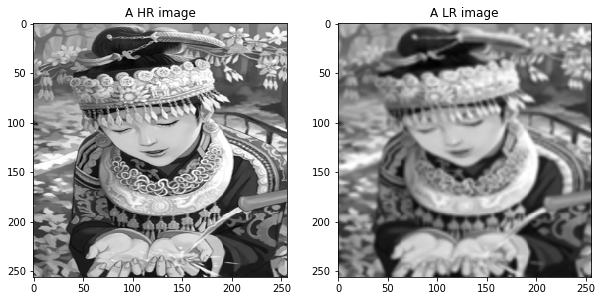

In [6]:
# Choose an image
ind = 3

if chan_num == 1:
    HR_ex=HR_test[ind,:,:,:].reshape(256,256)
    LR_ex=LR_test[ind,:,:,:].reshape(256,256)
else:
    HR_ex=HR_test[ind,:,:,:]
    LR_ex=LR_test[ind,:,:,:]

plt.rcParams['figure.figsize']=(10,10)
plt.figure()
plt.subplot(121)
plt.imshow(HR_ex,cmap='gray')
plt.title("A HR image")
plt.subplot(122)
plt.imshow(LR_ex,cmap='gray')
plt.title("A LR image")
plt.show()

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

**Create a function ```model``` which**
- Give as input the image size
- options are used to modify the u-net model (e.g., ``weight_decay``, ``activation``) and the training strategy(e.g., ``lr_decay``,``percept_loss``)
- Define as internal parameters 
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - the kernel size 
    - the initializer (try `glorot_normal`)
- Create an input layer using the Keras function ``Input``
- Declare the encoder blocks composed of:
    - two convolutional layers (with the same number of input channels). Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - **Hint** you may want to do this within a for loop to avoid errors in copy paste.
    - create a list with the encoder blocks to be able to point to them later.
- Define the decoder blocks composed of:
    - one Transpose convolution layer.
    - two convolutional layers. 
    - use relu activations
    - create a list with the encoder blocks to be able to point to them later.

- The output layer should be a Transpose convolution layer with a relu activation
- Create the skip connections 
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Define the keras model with ``Model``


#### 2.1.1 Set options

In [7]:
# Define options for model and training
weight_decay = None        #regularizers.l2(0.01) or None, whether use weight decay or not
param_activ_func = 0       #0 for relu, 0.3 for leaky relu
percept_loss = False       # whether use perceptual loss or not
lr_decay = False           # whether use learning rate decay or not
res_block = True          # whether add residual block

# Define filenames accordingly
path1 = '_Factor' + str(SR_factor)
path2 = '_' if weight_decay == None else '_WD_'
path3 = 'Relu' if param_activ_func == 0 else 'LeakyRelu'
path4 = '_PerceptLoss' if percept_loss == True else '_PixelLoss'
path5 = '_LRDecay' if lr_decay == True else '_LRFixed'
path6 = '_ResBlock' if res_block == True else '_'

savename = path1 + path2 + path3 + path4 + path5 + path6

#### 2.1.2 Design U-net architecture

In [8]:
# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block
    k_size = (3,3)                   #size of filter kernel
    k_init = glorot_normal(seed=42)  #kernel initializer
    #k_init = RandomNormal(mean=0.0, stddev=0.001, seed=42) # Initialization of SRCNN (Chao Dong et al.)
    
    # Use Keras Input layer to create one
    inp = Input((img_width, img_height,chan_num))
    
    # Encoder
    enc=[]
    
    for i in range(len(n_channels)):
        if i==0:
            pool=inp
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(pool)
        
        # Activation
        activ1 = Activation('relu')(conv1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(activ1)
        
        # Activation
        activ2 = Activation('relu')(conv2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv2)
        
        #Add output of this block to the encoder blocks list
        enc.append(activ2)
        
        # Pooling Layer
        if i==len(n_channels)-1:
            pool = activ2
        else:
            pool = MaxPooling2D(pool_size=(2,2), strides=2, data_format="channels_last")(activ2)

    # Decoder
    dec=[enc[-1]]
    
    for i in range(len(n_channels)-2, -1, -1):
        # Transpose Convolutional Layer
        trans_conv = Conv2DTranspose(filters=n_channels[i], kernel_size=(2,2), strides=2, padding="same", data_format="channels_last",
                                     activation=None, kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
        
        # Concatenating
        conca = concatenate([enc[i],trans_conv])
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(conca)
        
        # Activation
        activ1 = Activation('relu')(conv1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(activ1)
        
        # Activation
        activ2 = Activation('relu')(conv2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv2)
        
        #Add output of this block to the decoder blocks list
        dec.append(activ2)

    # Output
    #outp = Conv2DTranspose(filters=chan_num, kernel_size=(2,2), strides=1, padding="same", data_format="channels_last",
                           #activation='relu', kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
    outp = Conv2D(filters=chan_num, kernel_size=k_size, strides=1, padding="same", data_format="channels_last",
                  activation='relu', kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
    
    # Residual block
    if res_block == True:
        outp = add([inp,outp])
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    return model

#### 2.2. Define the losses and metrics

In [9]:
#MSE loss
def mse_loss(hr_img, sr_img):
    mse=K.mean(K.abs(hr_img-sr_img)**2)
    return mse

#Compute log10
def log10(x):
    numerator = K.log(x)
    denominator = K.log(K.constant(10, dtype=numerator.dtype))
    return numerator / denominator

#PSNR metric
def psnr(hr_img, sr_img):
    psnr = 20 * log10(1.0 / K.sqrt(mse_loss(hr_img, sr_img)))
    return psnr

#SSIM metric
def ssim(hr_img, sr_img):
    mu_h = K.mean(hr_img)
    mu_s = K.mean(sr_img)
    sig_h = K.std(hr_img)
    sig_s = K.std(sr_img)
    cov_hs = K.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

#### 2.3 Define optimizer 

In [10]:
# Set some model compile parameters
optimizer = keras.optimizers.Adam(lr=0.0001)
loss      = mse_loss #"mean_absolute_error"
metrics   = [psnr,ssim] if weight_decay == None else [mse_loss,psnr,ssim]

#### 2.4 Compile the model

In [11]:
# Compile the model and list its structure
model = unet_model(img_width, img_height)
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

#### 2.5. Define the perceptual loss

- If we want to use perceptual loss, ignore 2.2, 2.3, 2.4
- Instead of directly computing the loss between output images and the ground truth, we compute the loss between some features extracted from those two images.
- Here we use the pre-trained VGG-16 net to extract features.

In [12]:
# First let's make a main model (u-net model)
mainModel = unet_model(img_width, img_height)

# Then make a loss model (VGG-16 model)
from keras.applications.vgg16 import VGG16

lossModel = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width, img_height, 3))
lossModel.trainable=False

for layer in lossModel.layers:
    layer.trainable=False

# Select which layers' outputs will be used to compute loss
selectedLayers = ['block3_conv3']

#a list with the output tensors for each selected layer:
selectedOutputs = [lossModel.get_layer(name).output for name in selectedLayers]

#a new model with our chosen outputs:
lossModel = Model(lossModel.input,selectedOutputs) 

# VGG-16 requires 3-channel inputs
if chan_num == 1:
    vggInput = concatenate([mainModel.output,mainModel.output,mainModel.output])
else:
    vggInput = mainModel.output

# Connect mainModel.output with the lossModel
vggOutput = lossModel(vggInput)

# Create the full Model
fullModel = Model(inputs=mainModel.input, outputs=vggOutput)
fullModel.compile(loss='mse', optimizer='adam',metrics=['mse'])
fullModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_55 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_55[0][0]             
__________________________________________________________________________________________________
leaky_re_l

### 3. Trainning

#### 3.1 Train with visualization of the losses

#### 3.1.1 Use self-defined functions to visualize training process

In [12]:
#4S
# Runtime custom callbacks for loss visualization
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Loss", 'psnr': "PSNR(dB)", 'ssim': "SSIM", 'mse_loss': "Loss"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.LR = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())
        self.LR.append(K.get_value(self.model.optimizer.lr))
        
        metric_dir = "./saved_metrics"
        metric_path = 'metrics' + savename + '.svg'

        if not os.path.isdir(metric_dir):
            os.makedirs(metric_dir)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        if weight_decay == None:
            for metric_id, metric in enumerate(self.base_metrics):
                plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id + 1)
                plt.grid()

                plt.plot(range(1, len(self.logs) + 1),
                         [log[metric] for log in self.logs],
                         marker="o", label="training")
                if self.params['do_validation']:
                    plt.plot(range(1, len(self.logs) + 1),
                             [log['val_' + metric] for log in self.logs],
                             marker="o", label="validation")
                plt.title(translate_metric(metric))
                plt.xlabel('epoch')
                plt.legend(loc='center right')
            
            plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        else:
            for metric_id, metric in enumerate(self.base_metrics):
                if metric != 'loss':
                    plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id)
                    plt.grid()

                    plt.plot(range(1, len(self.logs) + 1),
                             [log[metric] for log in self.logs],
                             marker="o", label="training")
                    if self.params['do_validation']:
                        plt.plot(range(1, len(self.logs) + 1),
                                 [log['val_' + metric] for log in self.logs],
                                 marker="o", label="validation")
                    plt.title(translate_metric(metric))
                    plt.xlabel('epoch')
                    plt.legend(loc='center right')
            
            plt.subplot(2, (len(self.base_metrics))/2, len(self.base_metrics))
              
        #plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        plt.grid()
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.plot(range(1, len(self.logs) + 1),self.LR,marker="o")
        plt.title('Learning rate')
        plt.xlabel('epoch')
        
        plt.tight_layout()
        plt.savefig(os.path.join(metric_dir, metric_path),format='svg', dpi=1200)
        plt.show();
        
plot_losses = PlotLosses(figsize=(12.8, 8))

#### 3.1.2 Use TensorBoard to visualize training process

In [20]:
# Create a folder to put log file
log_dir = "C:\\Users\\ruizhi\\Desktop\\internship\\u_net_SR\\callback_tensorboard"
#if not os.path.isdir(model_dir):
#    os.makedirs(log_dir)

# Create a Tensorboard Callback
tb = TensorBoard(log_dir=log_dir,histogram_freq=1,batch_size=8,write_images=True)

#### 3.2 Launch the training (pixel loss)
- Use the model.fit function, and  
- save the final model. 
- Measure the overall time.


#### 3.2.1 Training

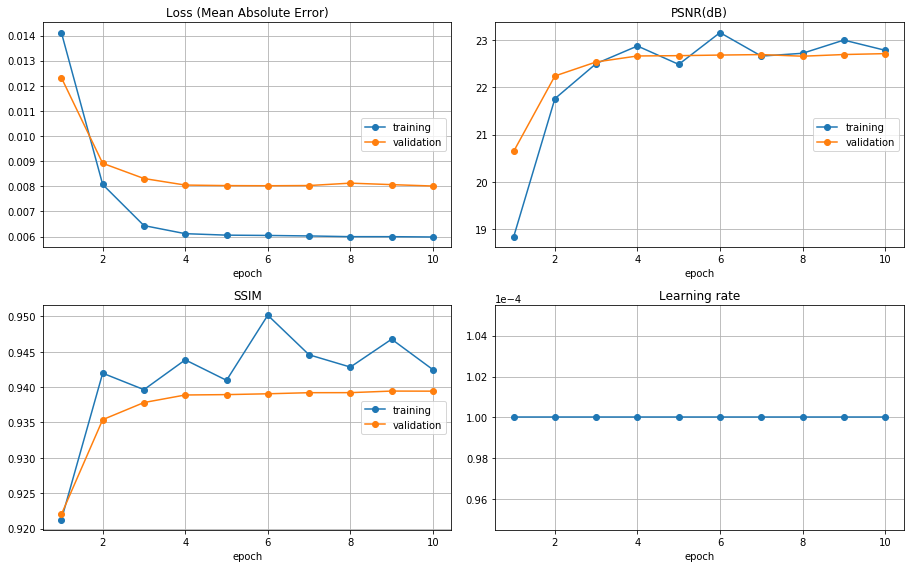


Epoch 00010: val_loss improved from 0.00802 to 0.00801, saving model to ./saved_model\model_Factor2_Relu_PixelLoss_LRFixed_ResBlock.hdf5

Epoch 00010: val_loss improved from 0.00802 to 0.00801, saving model to ./saved_weights\weights_Factor2_Relu_PixelLoss_LRFixed_ResBlock.h5
Wall time: 23min 3s


In [19]:
%%time

epochs=10
batch_size=8

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./saved_model"
weight_dir = "./saved_weights"
model_path = 'model' + savename + '.hdf5'
weight_path = 'weights' + savename + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='min')
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='min')

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
plt.ioff()
hist=model.fit(x=LR_train, y=HR_train, batch_size=batch_size, epochs=epochs,
               callbacks=cb_list, validation_split=0.1)#validation_data=(LR_valid,HR_valid))
plt.close('all')
plt.ion()

#### 3.2.2 Data augmentation

In [13]:
# Runtime data augmentation
def get_train_valid_augmented(X_data=LR_train, Y_data=HR_train, validation_split=0.1, batch_size=8, seed=seed):
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_valid, augment=True, seed=seed)
    Y_datagen_val.fit(Y_valid, augment=True, seed=seed)
    X_valid_augmented = X_datagen_val.flow(X_valid, batch_size=batch_size, shuffle=True, seed=seed)
    Y_valid_augmented = Y_datagen_val.flow(Y_valid, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    valid_generator = zip(X_valid_augmented, Y_valid_augmented)
    
    return train_generator, valid_generator

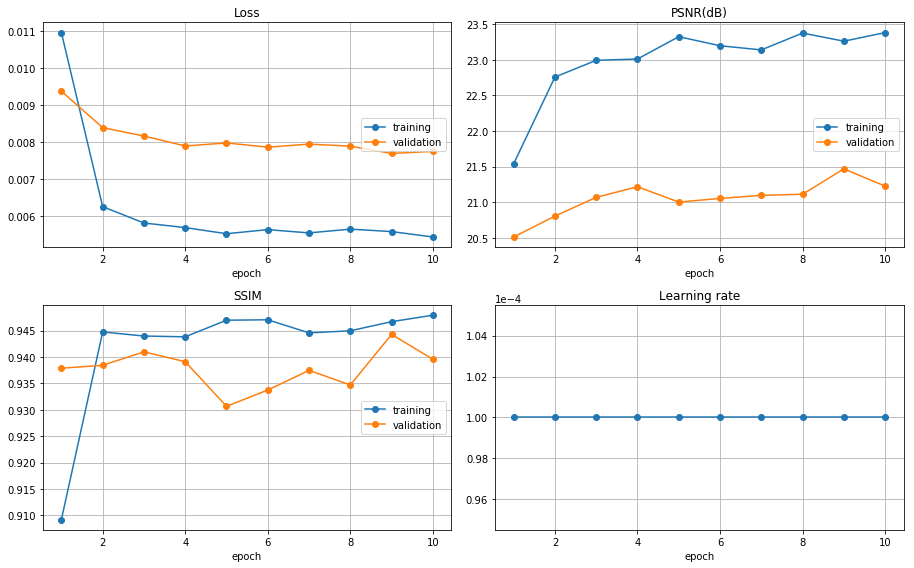


Epoch 00010: val_loss did not improve from 0.00769

Epoch 00010: val_loss did not improve from 0.00769
Wall time: 50min 8s


In [16]:
%%time

#Training with augmentation
epochs=10
batch_size=8

train_generator, valid_generator = get_train_valid_augmented(X_data=LR_train, Y_data=HR_train,
                                                           validation_split=0.1, batch_size=batch_size)

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./saved_model"
weight_dir = "./saved_weights"
model_path = 'model' + savename + '.hdf5'
weight_path = 'weights' + savename + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='min')
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='min')

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
validation_split = 0.1
steps_per_epoch = math.ceil(len(LR_train)*(1-validation_split)/batch_size)
validation_steps = math.ceil(len(LR_train)*validation_split/batch_size)

plt.ioff()
hist = model.fit_generator(generator=train_generator, validation_data=valid_generator, 
                           validation_steps=validation_steps,
                    steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, callbacks=cb_list)
plt.close('all')
plt.ion()

#### 3.2.3 Save the training history for further use

In [17]:
import pickle
# Save
hist_dir = "./saved_history"
hist_path = 'TrainHistory' + savename

if not os.path.isdir(hist_dir):
    os.makedirs(hist_dir)    

with open(os.path.join(hist_dir, hist_path), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# Load (optional)
#with open('TrainHistory', 'rb') as file_pi:
#    hist_loaded = pickle.load(file_pi)

#### 3.3 Launch the training (perceptual loss)
- Use the model.fit function, and  
- save the final model. 
- Measure the overall time.

In [1]:
%%time

epochs=1
batch_size=1

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./saved_model"
weight_dir = "./saved_weights"
model_path = 'model' + savename + '.hdf5'
weight_path = 'weights' + savename + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='min')
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='min')

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min')

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 5 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Put HR images to the loss model to generate corresponding feature ground truth
if chan_num == 1:
    triple_HR_train = np.concatenate((HR_train,HR_train,HR_train),axis=-1)
    #triple_HR_valid = np.concatenate((HR_valid,HR_valid,HR_valid),axis=-1)
else:
    triple_HR_train = HR_train
    #triple_HR_valid = HR_valid

HR_train_percept = lossModel.predict(triple_HR_train)
#HR_valid_percept = lossModel.predict(triple_HR_valid)
print(HR_train_percept.shape)
#print(HR_valid_percept.shape)

# Fit
plt.ioff()
hist_percept=fullModel.fit(x=LR_train, y=HR_train_percept, batch_size=batch_size, epochs=epochs,
                           callbacks=cb_list, validation_split=0.1)#validation_data=(LR_valid,HR_valid_percept))
plt.close('all')
plt.ion()

NameError: name 'PlotLosses' is not defined

#### 3.4 Load a trained model and continue training (optional)

In [40]:
#del model # Delete current model

# Select which model to load
weight_decay = None
param_activ_func = 0
percept_loss = False
lr_decay = True
res_block = True

# Define file name accordingly
path1 = '_Factor' + str(SR_factor)
path2 = '_' if weight_decay == None else '_WD_'
path3 = 'Relu' if param_activ_func == 0 else 'LeakyRelu'
path4 = '_PerceptLoss' if percept_loss == True else '_PixelLoss'
path5 = '_LRDecay' if lr_decay == True else '_LRFixed'
path6 = '_ResBlock' if res_block == True else '_'

path = path1 + path2 + path3 + path4 + path5 + path6
load_path = 'model' + path + '.hdf5'

# Define filepath and load
load_dir = "./saved_model"
model_file_name = os.path.join(load_dir, load_path)
model = load_model(model_file_name,custom_objects={'mse_loss': mse_loss, 'psnr': psnr, 'ssim': ssim})

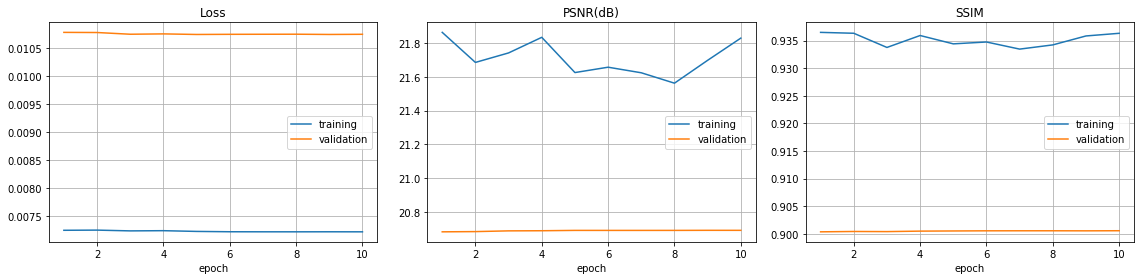


Epoch 00010: val_loss did not improve from 0.01075

Epoch 00010: val_loss did not improve from 0.01075
Wall time: 47min 50s


In [41]:
%%time

epochs=10
batch_size=8

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./saved_model"
weight_dir = "./saved_weights"
model_path = 'model_continue_training' + savename + '.hdf5'
weight_path = 'weights_continue_training' + savename + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='min')
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='min')

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 5 epochs
        if epoch % 5 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
plt.ioff()
hist_continue=model.fit(x=LR_train, y=HR_train, batch_size=batch_size, epochs=epochs,
                        callbacks=cb_list, validation_split=0.1)#validation_data=(LR_valid,HR_valid))
plt.close('all')
plt.ion()

In [ ]:
# Save history file
hist_dir = "./saved_history"
hist_path = 'ContinueTrainHistory' + savename

if not os.path.isdir(hist_dir):
    os.makedirs(hist_dir)    

with open(os.path.join(hist_dir, hist_path), 'wb') as file_pi:
    pickle.dump(hist_continue.history, file_pi)

### 4. Test phase

#### 4.1 Reload the model and the test data
Reload the keras model and fill it with the saved weights ``model_loaded.load_weights``

In [18]:
# Select which model to load
weight_decay = None
param_activ_func = 0
percept_loss = False
lr_decay = False
res_block = True

# Define loadname accordingly
path1 = '_Factor' + str(SR_factor)
path2 = '_' if weight_decay == None else '_WD_'
path3 = 'Relu' if param_activ_func == 0 else 'LeakyRelu'
path4 = '_PerceptLoss' if percept_loss == True else '_PixelLoss'
path5 = '_LRDecay' if lr_decay == True else '_LRFixed'
path6 = '_ResBlock' if res_block == True else '_'

loadname = path1 + path2 + path3 + path4 + path5 + path6
load_path = 'weights' + loadname + '.h5'

load_dir = "./saved_weights"
load_path = os.path.join(load_dir, load_path)
model_loaded = unet_model(img_width=img_width, img_height=img_height)
model_loaded.load_weights(load_path)
model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)


#### 4.2 Use model to predict test labels


In [19]:
#4S
SR_test = model_loaded.predict(LR_test, verbose=1)
print(SR_test.shape, SR_test.dtype)

13/13 [==============================] - 6s 450ms/step
(13, 256, 256, 1) float32


#### 4.3 Compute metrics on test set


In [20]:
# Compute PSNR on test set
def compute_psnr(hr_img, sr_img):
    mse=np.mean(abs(sr_img-hr_img)**2)
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

def compute_ssim(hr_img, sr_img):
    mu_h = np.mean(hr_img)
    mu_s = np.mean(sr_img)
    sig_h = np.std(hr_img)
    sig_s = np.std(sr_img)
    cov_hs = np.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

psnr_bicubic=[]
psnr_sr=[]
ssim_bicubic=[]
ssim_sr=[]

for i in range(LR_test.shape[0]):
    psnr_bicubic.append(compute_psnr(HR_test[i,:,:,:],LR_test[i,:,:,:]))
    psnr_sr.append(compute_psnr(HR_test[i,:,:,:],SR_test[i,:,:,:]))
    ssim_bicubic.append(compute_ssim(HR_test[i,:,:,:],LR_test[i,:,:,:]))
    ssim_sr.append(compute_ssim(HR_test[i,:,:,:],SR_test[i,:,:,:]))

print('bicubic psnr on test set:',psnr_bicubic,'dB')
print('SR psnr on test set:',psnr_sr,'dB')
print('bicubic ssim on test set:',ssim_bicubic)
print('SR ssim on test set:',ssim_sr)

bicubic psnr on test set: [16.779044836182365, 22.286950053471386, 26.87166770021716, 22.133203391231856, 33.013439186568114, 24.42262158432805, 26.536972695575226, 22.9773716015233, 21.61654018793538, 22.386671284701016, 22.201118650728656, 19.831560999379715, 21.668705373359842] dB
SR psnr on test set: [16.19196029171818, 21.539615874264516, 24.97676667759951, 23.36031183740042, 27.014483824697407, 23.89107471165468, 28.855160165795365, 22.757661350013933, 19.878384762316504, 23.965438884153507, 20.955763231337485, 19.756868678906383, 21.384005491879993] dB
bicubic ssim on test set: [0.8514656246990284, 0.9364126209562589, 0.9756462224026119, 0.9552128236504837, 0.9958839433317412, 0.9617513528813533, 0.9874000820994318, 0.9550042074180682, 0.9558891317547221, 0.9096302992640374, 0.9721230846701875, 0.9403682635997715, 0.9259449923141772]
SR ssim on test set: [0.8575437909290303, 0.9391584803999751, 0.9641725227663418, 0.9567570657130056, 0.9858117893153986, 0.9567386474458441, 0.990

#### 4.4 Visualize predictions on a random element of the test data

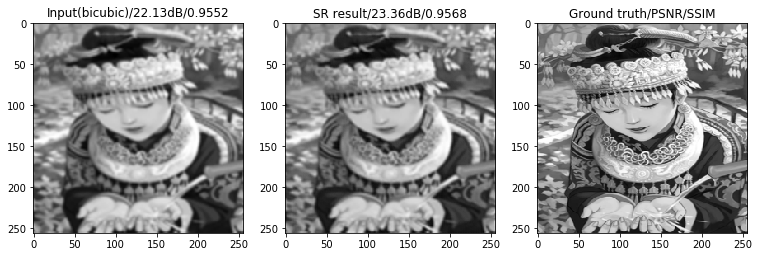

In [21]:
# Choose an image
ind = 3

if chan_num == 1:
    HR_ex=HR_test[ind,:,:,:].reshape(256,256)
    LR_ex=LR_test[ind,:,:,:].reshape(256,256)
    SR_ex=SR_test[ind,:,:,:].reshape(256,256)
else:
    HR_ex=HR_test[ind,:,:,:]
    LR_ex=LR_test[ind,:,:,:]
    SR_ex=SR_test[ind,:,:,:]

result_dir = "./saved_results"
result_path = 'result' + loadname + '.svg'

if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

plt.rcParams['figure.figsize']=(12.8,12.8)
plt.figure()
plt.subplot(131)
plt.imshow(LR_ex,cmap='gray')
plt.title("Input(bicubic)/{0:.2f}dB/{1:.4f}".format(psnr_bicubic[ind],ssim_bicubic[ind]))
plt.subplot(132)
plt.imshow(SR_ex,cmap='gray')
plt.title("SR result/{0:.2f}dB/{1:.4f}".format(psnr_sr[ind],ssim_sr[ind]))
plt.subplot(133)
plt.imshow(HR_ex,cmap='gray')
plt.title("Ground truth/PSNR/SSIM")
plt.savefig(os.path.join(result_dir, result_path), format='svg',dpi=1200)
plt.show()

### 5. Compare validation loss of different models

In [7]:
import pickle
with open('TrainHistory_Factor2_Relu_PixelLoss_LRFixed_', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_base=hist_loaded['val_loss']

with open('TrainHistory_Factor2_LeakyRelu_PixelLoss_LRFixed_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_leaky=hist_loaded['val_loss']

with open('TrainHistory_Factor2_Relu_PixelLoss_LRDecay1e-4_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_lrdecay=hist_loaded['val_loss']

with open('TrainHistory_Factor2_Relu_PixelLoss_LRFixed1e-4_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_res=hist_loaded['val_loss']

with open('TrainHistory_Factor2_WD_Relu_PixelLoss_LRFixed_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_wd=hist_loaded['val_mse_loss']

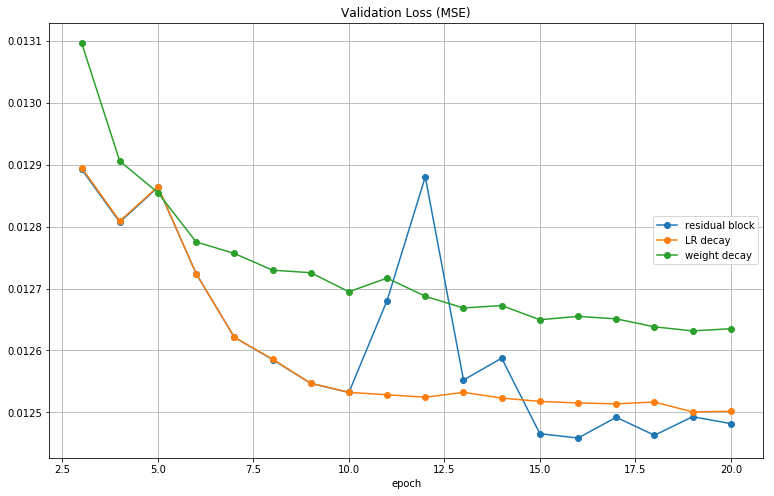

In [13]:
plt.figure(figsize=(12.8,8))
plt.grid()
#plt.plot(range(3, len(loss_base) + 1),loss_base[2:20],marker="o", label="basic model")
plt.plot(range(3, len(loss_res) + 1),loss_res[2:20],marker="o", label="residual block")
plt.plot(range(3, len(loss_lrdecay) + 1),loss_lrdecay[2:20],marker="o", label="LR decay")
#plt.plot(range(3, len(loss_leaky) + 1),loss_leaky[2:20],marker="o", label="leaky relu")
plt.plot(range(3, len(loss_wd) + 1),loss_wd[2:20],marker="o", label="weight decay")
plt.title('Validation Loss (MSE)')
plt.xlabel('epoch')
plt.legend(loc='center right')
plt.savefig('valid_loss2.svg',format='svg', dpi=1200)
plt.show()